# Audio processing lab

This notebook contains an exploration of audio processing techniques. 

The `wav_data_loader()` uses Librosa's framwork to load wav files as numpy arrays.

Two different Mel spectrogram functions are built to generate the spectrograms: 

    - With Librosa: `librosa_mel_spectrogram()`
    
    - With thensorflow: `tf_mel_spectrogram()`

Waveform and spectrogram data agumentation techniques are explored.

The function `split_waveforms()` will apply splitting frames to the audio fragments.

In [1]:
# IMPORT ALL LIBRARIES

import numpy as np
import matplotlib.pyplot as plt
import os
import random

import IPython.display as ipd
import librosa
import librosa.display

import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Load the data
### ESC-50 Dataset
This processing lab is configured using the ESC-50 dataset.

In [2]:
# Determine the Sample Rate to load the audio files

SR = 16000

In [3]:
info = pd.read_csv('/kaggle/input/esc50dataset/ESC-50-master/ESC-50-master/meta/esc50.csv')

info_list = list(info['category'].unique())

labels = {}

for i, label in enumerate(info_list):
        labels[label] = i

NUM_CLASSES = len(labels)

# Create a new empty dictionary
reversed_labels = {}

# Iterate through the key-value pairs in the dictionary
for key, value in labels.items():
  # Add the key-value pair to the new dictionary in the reverse order
  reversed_labels[value] = key
    
esc50_files = list(info['filename'])

In [4]:
info['category'].value_counts()

dog                 40
glass_breaking      40
drinking_sipping    40
rain                40
insects             40
laughing            40
hen                 40
engine              40
breathing           40
crying_baby         40
hand_saw            40
coughing            40
snoring             40
chirping_birds      40
toilet_flush        40
pig                 40
washing_machine     40
clock_tick          40
sneezing            40
rooster             40
sea_waves           40
siren               40
cat                 40
door_wood_creaks    40
helicopter          40
crackling_fire      40
car_horn            40
brushing_teeth      40
vacuum_cleaner      40
thunderstorm        40
door_wood_knock     40
can_opening         40
crow                40
clapping            40
fireworks           40
chainsaw            40
airplane            40
mouse_click         40
pouring_water       40
train               40
sheep               40
water_drops         40
church_bells        40
clock_alarm

#### Load the wav files
The deep learning model accepts samples in the range [-1.0, 1.0] 

The data loader runs normalization with librosa's integrated util: https://librosa.org/doc/main/generated/librosa.util.normalize.html

`wav_data_loader()` loads the wav files with their corresponding labels as a tuple.

In [5]:
ESC50_FOLDER = '/kaggle/input/esc50dataset/ESC-50-master/ESC-50-master/audio'

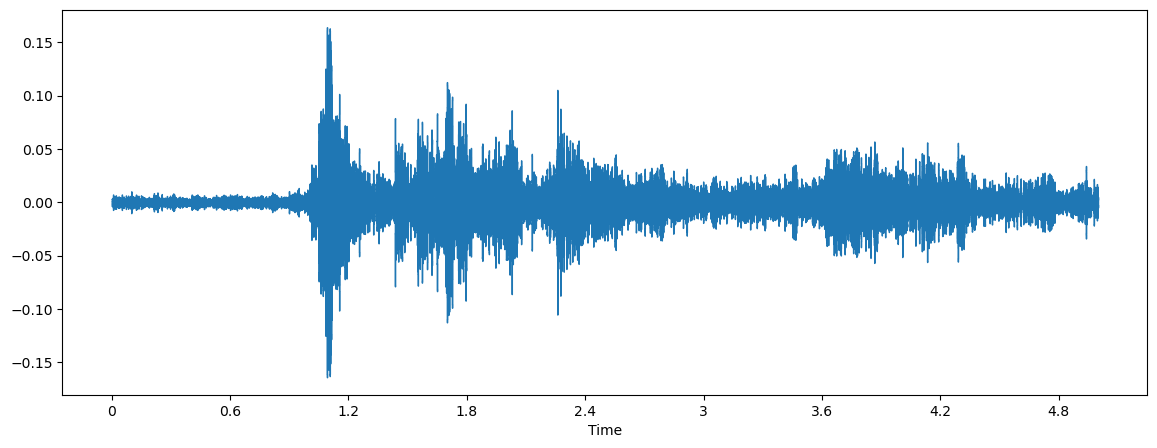

In [6]:
# Original sample

TEST_FILE = os.path.join(ESC50_FOLDER, esc50_files[5])
        
sample, sample_rate = librosa.load(TEST_FILE, sr=SR)
        
plt.figure(figsize=(14, 5))
librosa.display.waveshow(sample, sr=SR)

# Play the WAV audio
ipd.Audio(sample, rate=SR)

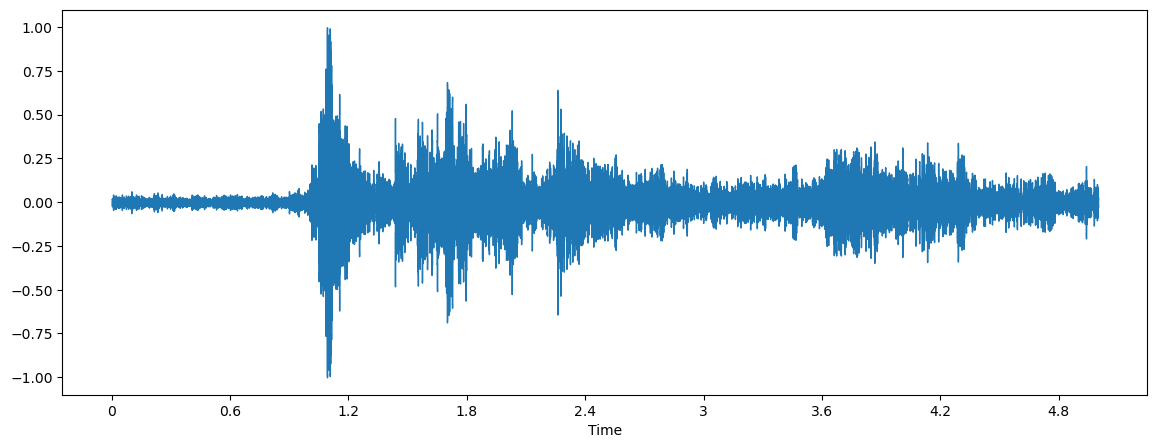

In [7]:
# Normalized sample

norm_sample = librosa.util.normalize(sample)

plt.figure(figsize=(14, 5))
librosa.display.waveshow(norm_sample, sr=SR)

In [8]:
def wav_data_loader(files, normalization=True):
    
    all_fragments = []
    
    for file in files:
        
        # Load the audio file
        
        AUDIO_FILE = os.path.join(ESC50_FOLDER, file)
        
        sample, sample_rate = librosa.load(AUDIO_FILE, sr=SR)
        
        if normalization==True:
            
            # Normalize the waveform
            sample = librosa.util.normalize(sample)
        
        cat = info[info['filename'] == file]['category'].iloc[0]
        
        sample = (sample, labels[cat])    
    
        all_fragments.append(sample)
    
    return all_fragments

In [10]:
%%time
esc50_wav_dataset = wav_data_loader(esc50_files)

CPU times: user 1.58 s, sys: 216 ms, total: 1.79 s
Wall time: 4.06 s


## Acoustic feature extraction

Acoustic features are extracted by computing the Mel Spectrogram.

The spectrograms are computed using two alternative libraries: librosa and tf. 

The results are slightly different due to the complexity of the computation and the large number of dependencies. 

The mel sgram has been computed using the parameters determined in the yamnet model: https://github.com/tensorflow/models/tree/master/research/audioset/yamnet

*Note: normalization has been included within the `tf_mel_spectrogram()` function, as it will be a useful feature in the future. It is important to run `normalization=False` in the data loader to use the TensorFlow based spectrogram generator properly.*

In [12]:
def tf_mel_spectrogram(wav, sample_rate=SR, num_mel_bins=64, lower_freq=125, upper_freq=7500, log_offset=0.001):
    
    # Convert numpy array to Tensor and normalize based on its actual max and min values
    wav = tf.cast(wav, tf.float32)
    audio_tensor = (wav - tf.math.reduce_min(wav)) / (tf.math.reduce_max(wav) - tf.math.reduce_min(wav)) * 2 - 1

    # Calculate the frame_length and frame_step based on window size and hop size
    frame_length = int(sample_rate * 0.025)  # 25 ms window
    frame_step = int(sample_rate * 0.01)  # 10 ms hop

    # Calculate the spectrogram
    spectrogram = tf.signal.stft(audio_tensor, frame_length=frame_length, frame_step=frame_step)

    # Calculate the magnitude of the spectrogram
    magnitude_spectrogram = tf.abs(spectrogram)

    # Define the parameters for the Mel scale
    num_spectrogram_bins = magnitude_spectrogram.shape[-1]
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sample_rate, lower_freq, upper_freq)

    # Convert the spectrogram to the Mel scale
    mel_spectrogram = tf.tensordot(magnitude_spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrogram.set_shape(magnitude_spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

    # Apply a logarithmic scale
    log_mel_spectrogram = tf.math.log(mel_spectrogram + log_offset)

    return log_mel_spectrogram.numpy()


def librosa_mel_spectrogram(wav, sample_rate=SR, num_mel_bins=64, lower_freq=125, upper_freq=7500, log_offset=0.001):
    # Compute the Short-Time Fourier Transform (STFT) with a window size of 25 ms, a window hop of 10 ms, and a periodic Hann window
    n_fft = int(sample_rate * 0.025)  # Window size of 25 ms
    hop_length = int(sample_rate * 0.01)  # Window hop of 10 ms
    window = 'hann'  # Periodic Hann window

    stft = librosa.stft(wav, n_fft=n_fft, hop_length=hop_length, window=window)
    spectrogram = np.abs(stft)

    # Map the spectrogram to 64 mel bins covering the range 125-7500 Hz
    mel_filter = librosa.filters.mel(sr=sample_rate, n_fft=n_fft, n_mels=num_mel_bins, fmin=lower_freq, fmax=upper_freq)
    mel_spectrogram = mel_filter.dot(spectrogram)

    # Compute a stabilized log mel spectrogram
    log_mel_spectrogram = np.log(mel_spectrogram + log_offset)

    # Transpose the output. Librosa outputs spectrogram of shape (n_mel_bins, T)
    log_mel_spectrogram = log_mel_spectrogram.T

    return log_mel_spectrogram

### Testing the mel spectrograms on a wav file

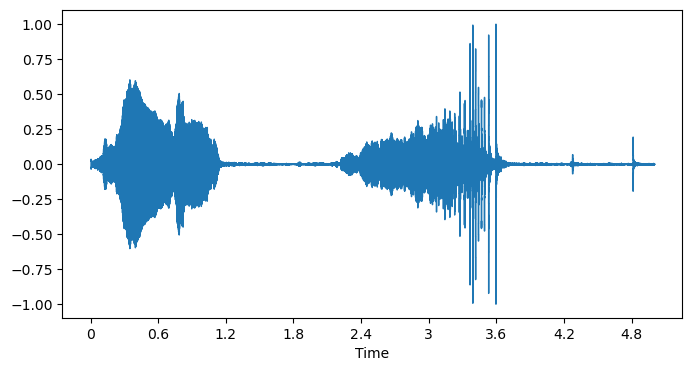

In [13]:
plt.figure(figsize=(8,4))
librosa.display.waveshow(esc50_wav_dataset[79][0], sr=SR)

# Play the WAV audio
ipd.Audio(esc50_wav_dataset[79][0], rate=SR)

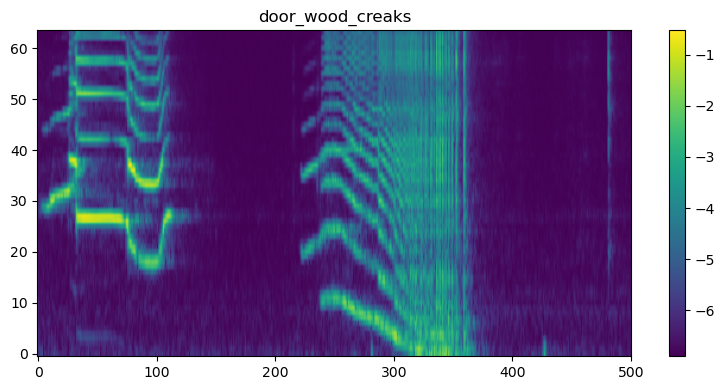

In [14]:
# Transpose the spectrogram
spectrogram = librosa_mel_spectrogram(esc50_wav_dataset[79][0]).T

# Create a figure
fig, ax = plt.subplots(figsize=(8,4))

# Set the title using the reversed_labels
ax.set_title(reversed_labels[esc50_wav_dataset[79][1]])

# Display the spectrogram
img = ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')

# Add a colorbar
fig.colorbar(img, ax=ax)

# Ensure the layout is tight
plt.tight_layout()

# Show the plot
plt.show()

In [15]:
%%time

librosa_specs = []

librosa_specs = list(map(lambda x: (librosa_mel_spectrogram(x[0]),x[1]), esc50_wav_dataset))

CPU times: user 5.31 s, sys: 4.22 s, total: 9.53 s
Wall time: 2.45 s


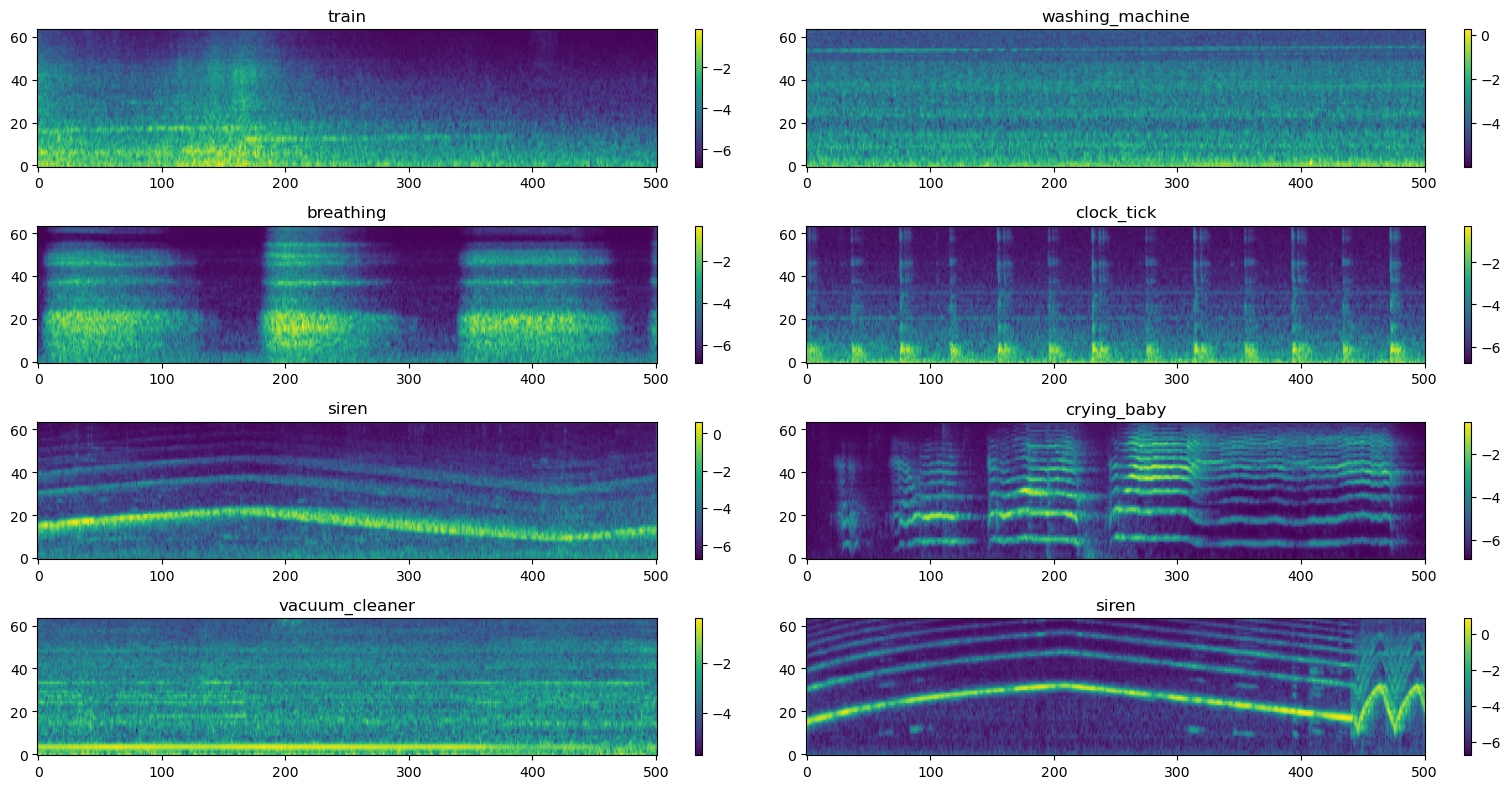

In [16]:
# View 8 random spectrograms
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16,8))

# Generate 8 random indices
indices = np.random.choice(len(librosa_specs), size=8, replace=False)

for i, ax in enumerate(axs.ravel()):
    idx = indices[i]  # use the randomly generated index
    ax.set_title(reversed_labels[librosa_specs[idx][1]])
    spectrogram = librosa_specs[idx][0].T  # Transpose the spectrogram
    img = ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
    fig.colorbar(img, ax=ax)

plt.tight_layout()
plt.show()

In [17]:
%%time

tf_specs = []

tf_specs = list(map(lambda x: (tf_mel_spectrogram(x[0]),x[1]), esc50_wav_dataset))

CPU times: user 6.41 s, sys: 188 ms, total: 6.6 s
Wall time: 6.35 s


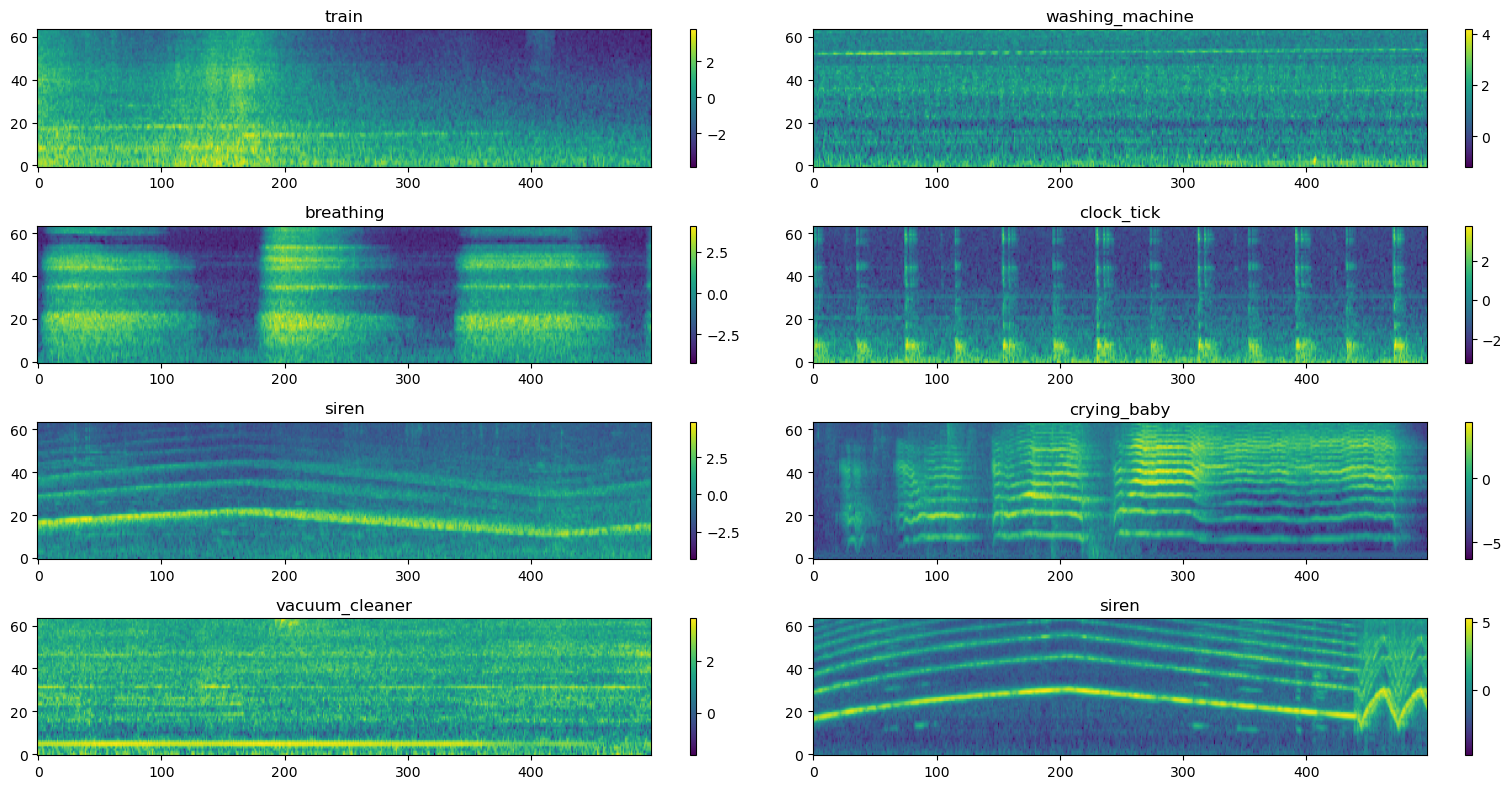

In [18]:
# View 8 random spectrograms
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16,8))

for i, ax in enumerate(axs.ravel()):
    idx = indices[i]  # use the randomly generated index
    ax.set_title(reversed_labels[tf_specs[idx][1]])
    spectrogram = tf_specs[idx][0].T  # Transpose the spectrogram
    img = ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
    fig.colorbar(img, ax=ax)

plt.tight_layout()
plt.show()

In [19]:
librosa_specs[5][0].shape

(501, 64)

In [20]:
tf_specs[5][0].shape

(498, 64)

This difference in shape can be adjusted manually to create two equivalent functions. Further investigation of acoustic feature extraction is required.

## Data augmentation techniques
### Waveform augmentation

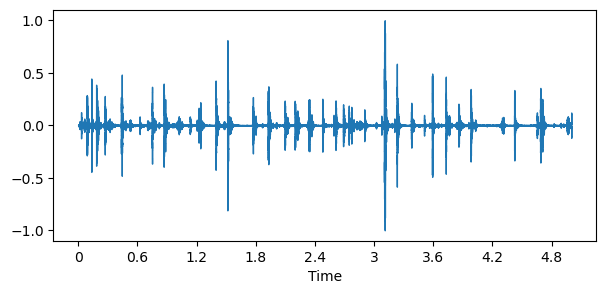

In [22]:
# Original sample

test_wav = esc50_wav_dataset[86][0]
        
plt.figure(figsize=(7, 3))
librosa.display.waveshow(test_wav, sr=SR)

# Play the WAV audio
ipd.Audio(test_wav, rate=SR)

In [23]:
## Noise addition

def add_noise(wav_data, noise_factor):

    # Generate noise signal with the same shape as input waveform
    noise = np.random.normal(0, 1, len(wav_data))

    # Scale noise signal with the permissible noise factor value
    noise *= noise_factor

    # Add noise signal to input waveform
    augmented_wav_data = wav_data + noise

    # Normalize the augmented waveform data
    augmented_wav_data = librosa.util.normalize(augmented_wav_data)

    return augmented_wav_data

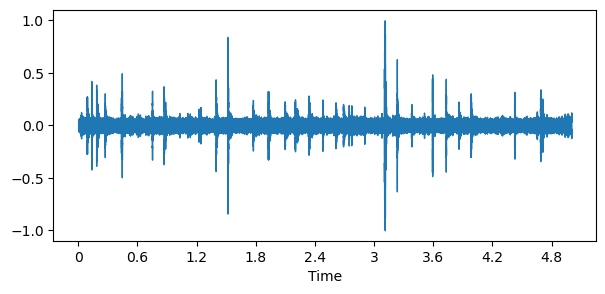

In [24]:
# We want to use noise factors between 0.005 and 0.04

noise_test_wav = add_noise(test_wav, 0.025)

plt.figure(figsize=(7, 3))
librosa.display.waveshow(noise_test_wav, sr=SR)

# Play the WAV audio
ipd.Audio(noise_test_wav, rate=SR)

In [25]:
# Wav data augmentation through time shift

def time_shift(audio, p):
    """
    Shift audio to the left or right by a random amount.
    """
    # Calculate the length of the audio array
    length = audio.shape[0]

    # Calculate the maximum number of samples to shift
    max_shift = int(length * p)

    # Generate a random shift value
    shift = random.randint(-max_shift, max_shift)

    # Create an empty array with the same shape as the audio array
    shifted_audio = np.zeros_like(audio)

    # Shift the audio by the specified number of samples
    if shift > 0:
      # Shift to the right
        shifted_audio[shift:] = audio[:length-shift]
    else:
        # Shift to the left
        shifted_audio[:length+shift] = audio[-shift:]
    
    if np.sum(shifted_audio) == 0:
        #revert the process if all information was erased
        shifted_audio = audio     

    return shifted_audio

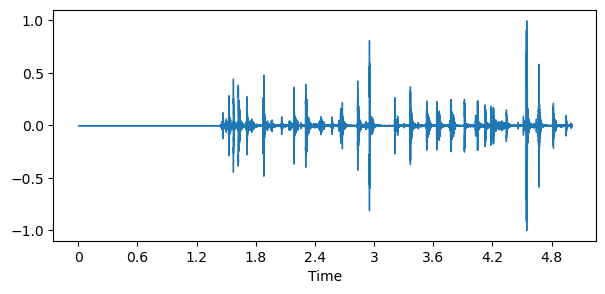

In [26]:
# We want to use maximum shift of 0.4

shift_test_wav = time_shift(test_wav, 0.4)

plt.figure(figsize=(7, 3))
librosa.display.waveshow(shift_test_wav, sr=SR)

# Play the WAV audio
ipd.Audio(shift_test_wav, rate=SR)

In [27]:
def time_stretching(audio,factor):
    
    wav_time_stch = librosa.effects.time_stretch(audio,rate=factor)
    
    return wav_time_stch[:SR*5]

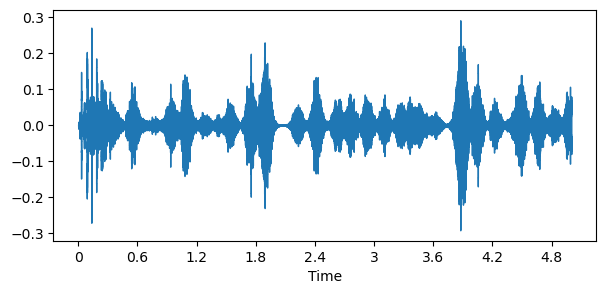

In [28]:
# We strecth the audio and take only the 2 second fragment.

strch_test_wav = time_stretching(test_wav, 0.8)

plt.figure(figsize=(7, 3))
librosa.display.waveshow(strch_test_wav, sr=SR)

# Play the WAV audio
ipd.Audio(strch_test_wav, rate=SR)

### Spectrogram augmentation

In [36]:
# SPECTROGRAM AUGMENTATION

def frequency_mask(spectrogram, p):
    """
    Mask out two percentages of frequencies from the spectrogram.
    """

    # Generate two random start and end points for the masks
    start1 = random.randint(0, spectrogram.shape[0] - 1)
    end1 = min(start1 + int(spectrogram.shape[0]*p), spectrogram.shape[0])

    start2 = random.randint(0, spectrogram.shape[0] - 1)
    end2 = min(start2 + int(spectrogram.shape[0]*p), spectrogram.shape[0])

    # If masks are overlapping, adjust the second mask
    while start1 <= end2 and end1 >= start2:
        start2 = random.randint(0, spectrogram.shape[0] - 1)
        end2 = min(start2 + int(spectrogram.shape[0]*p), spectrogram.shape[0])

    # Create a mask with the same shape as the spectrogram
    mask = np.ones(spectrogram.shape)

    # Set the mask values to zero within the specified range of frequencies
    mask[start1:end1, :] = 0
    mask[start2:end2, :] = 0

    # Apply the mask to the spectrogram
    masked_spectrogram = spectrogram * mask

    return masked_spectrogram

def time_mask(spectrogram, p):
    """
    Mask out two percentages of time from the spectrogram.
    """

    # Generate two random start and end points for the masks
    start1 = random.randint(0, spectrogram.shape[1] - 1)
    end1 = min(start1 + int(spectrogram.shape[1]*p), spectrogram.shape[1])

    start2 = random.randint(0, spectrogram.shape[1] - 1)
    end2 = min(start2 + int(spectrogram.shape[1]*p), spectrogram.shape[1])

    # If masks are overlapping, adjust the second mask
    while start1 <= end2 and end1 >= start2:
        start2 = random.randint(0, spectrogram.shape[1] - 1)
        end2 = min(start2 + int(spectrogram.shape[1]*p), spectrogram.shape[1])

    # Create a mask with the same shape as the spectrogram
    mask = np.ones(spectrogram.shape)

    # Set the mask values to zero within the specified range of time
    mask[:, start1:end1] = 0
    mask[:, start2:end2] = 0

    # Apply the mask to the spectrogram
    masked_spectrogram = spectrogram * mask

    return masked_spectrogram

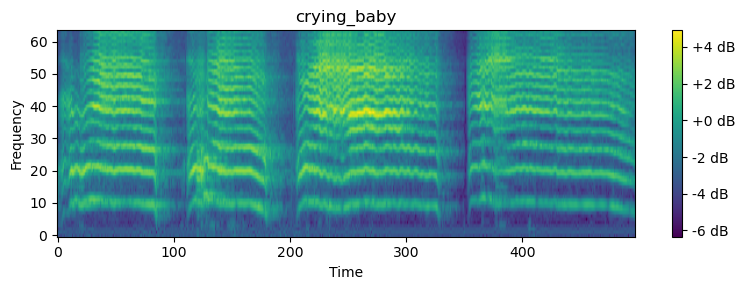

In [37]:
# Generate a random index
index = np.random.choice(len(tf_specs))

# Select the spectrogram
spectrogram = tf_specs[index][0].T

# Create a new figure
plt.figure(figsize=(8, 3))

# Display the spectrogram
plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')

# Set title as the label of the spectrogram
plt.title(reversed_labels[tf_specs[index][1]])

# Add a colorbar
plt.colorbar(format='%+2.0f dB')

# Set labels
plt.xlabel('Time')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()

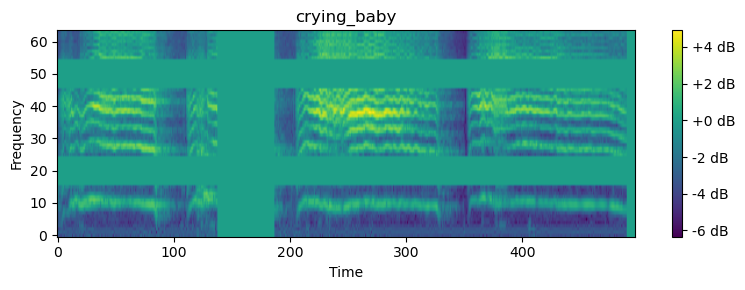

In [38]:
# Apply frequency and time masking
augmented_spectrogram = frequency_mask(spectrogram, 0.15)  # change 'p' as needed
augmented_spectrogram = time_mask(augmented_spectrogram, 0.1)  # change 'p' as needed

# Create a new figure
plt.figure(figsize=(8, 3))

# Display the spectrogram
plt.imshow(augmented_spectrogram, aspect='auto', origin='lower', cmap='viridis')

# Set title as the label of the spectrogram
plt.title(reversed_labels[tf_specs[index][1]])

# Add a colorbar
plt.colorbar(format='%+2.0f dB')

# Set labels
plt.xlabel('Time')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()

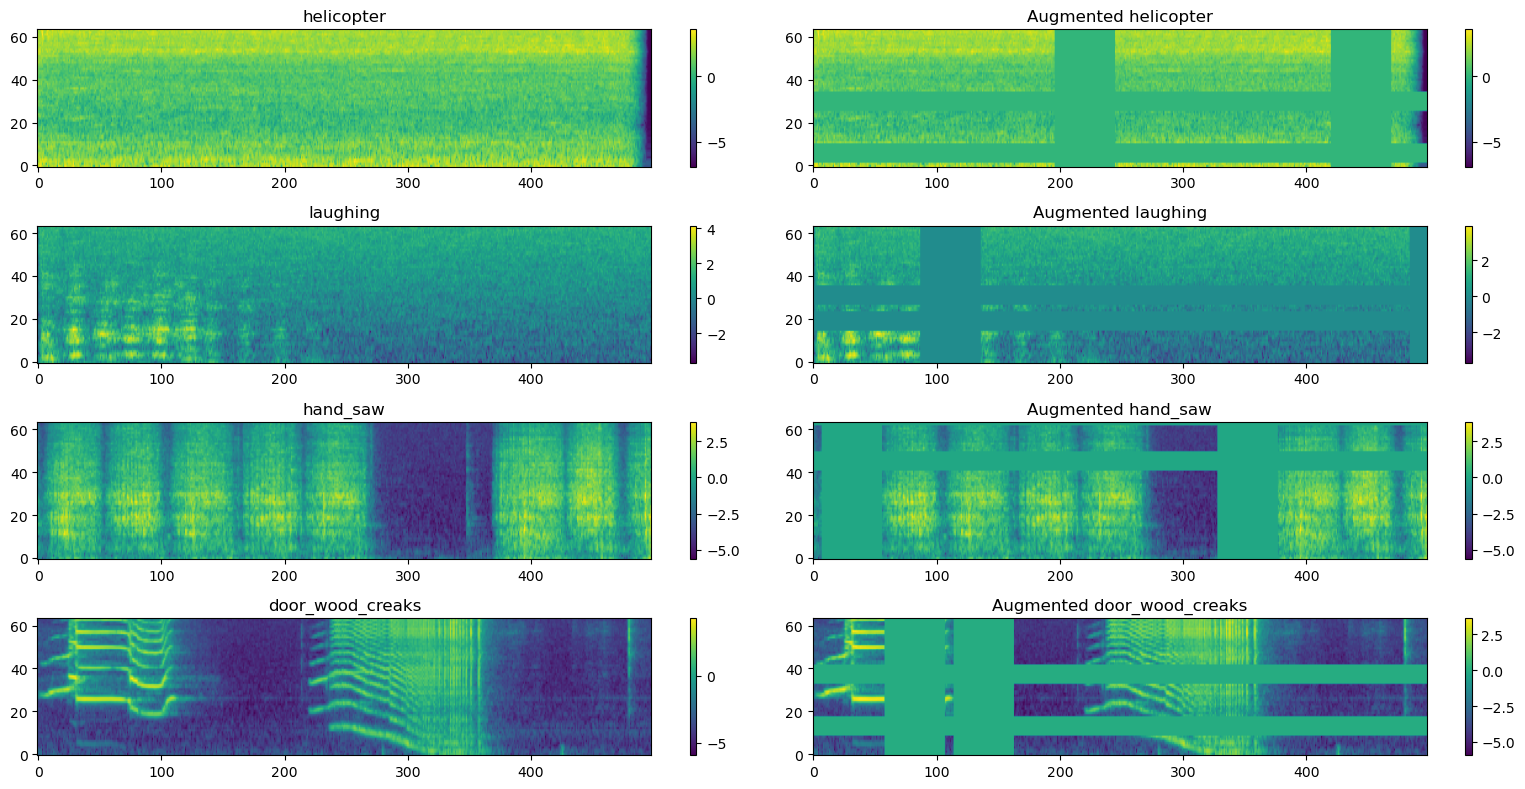

In [39]:
# View 4 random spectrograms and their augmented versions
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16,8))

# Generate 4 random indices
indices = np.random.choice(len(y_train), size=4, replace=False)

for i in range(4):
    idx = indices[i]  # use the randomly generated index
    spectrogram = tf_specs[idx][0].T  # Transpose the spectrogram

    # Original spectrogram
    ax = axs[i, 0]
    ax.set_title(reversed_labels[tf_specs[idx][1]])
    img = ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
    fig.colorbar(img, ax=ax)

    # Augmented spectrogram
    ax = axs[i, 1]
    ax.set_title('Augmented ' + reversed_labels[tf_specs[idx][1]])
    # Apply frequency and time masking
    augmented_spectrogram = frequency_mask(spectrogram, 0.15)
    augmented_spectrogram = time_mask(augmented_spectrogram, 0.1)
    img = ax.imshow(augmented_spectrogram, aspect='auto', origin='lower', cmap='viridis')
    fig.colorbar(img, ax=ax)

plt.tight_layout()
plt.show()

## Splitting waveforms
This function will split waveforms with a window size of 2 seconds and a hop size of 0.5 seconds.

In [47]:
def split_waveforms(wav, y, sample_rate=SR, window_size=2, hop_size=0.5):
    
    # Define window size and hop size in samples
    window_size = window_size * sample_rate 
    hop_size = hop_size * sample_rate

    X_segments = []
    y_segments = []
    
    for start in np.arange(0, wav.size - window_size + 1, hop_size):
        end = start + window_size
        segment = wav[int(start):int(end)]
        X_segments.append(segment)
        y_segments.append(y)

    return X_segments, y_segments

In [61]:
splitted_wav, labels = split_waveforms(tf_specs[117][0], tf_specs[117][1])

In [62]:
len(splitted_wav)

7

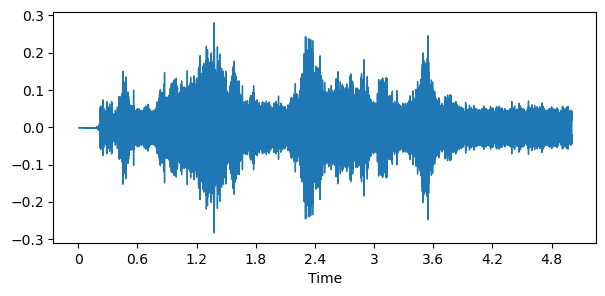

In [63]:
plt.figure(figsize=(7, 3))
librosa.display.waveshow(tf_specs[117][0], sr=SR)

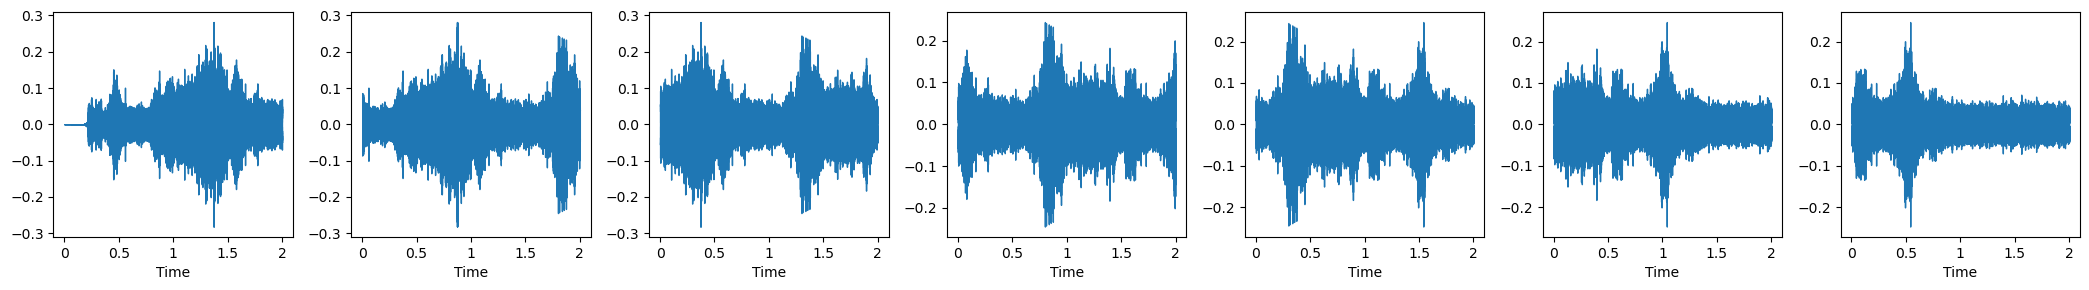

In [66]:
fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(21, 3))  # Adjust the figure size as needed

for i in range(7):
    librosa.display.waveshow(splitted_wav[i], sr=SR, ax=axs[i])  # SR is your sample rate

plt.tight_layout()  # This ensures that the subplots do not overlap
plt.show()